In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch
import os
import torch
import torchaudio
import torchaudio.functional as F


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


# Загрузка и фильтрация данных

In [3]:
ds = load_dataset("MegaKosT/RuDevSberDS")

Using custom data configuration MegaKosT--RuDevSberDS-c815bd8b35ec831d
Found cached dataset parquet (/root/.cache/huggingface/datasets/MegaKosT___parquet/MegaKosT--RuDevSberDS-c815bd8b35ec831d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 428.19it/s]


In [4]:
len(ds['train'])
len(ds['test'])

9225

In [5]:
import datasets
datasets.__version__

'2.9.0'

In [6]:
print(torch.__version__)
print(torchaudio.__version__)

1.13.1+cu117
0.13.1+cu117


In [7]:
ds_train = ds['train'].select(range(20000))
ds_test = ds['test'].select(range(5000))
len(ds_train)

20000

In [8]:
ds_train[0]['audio']

{'path': '00003ec0-1257-42d1-b475-db1cd548092e.wav',
 'array': array([ 0.00787354,  0.00735474,  0.00714111, ..., -0.00018311,
        -0.00015259, -0.00018311]),
 'sampling_rate': 16000}

In [9]:
ds_train = ds_train.filter(
    lambda it1: (it1["transcription"] is not None) and (len(it1["transcription"].strip()) > 0)
)
ds_test = ds_test.filter(
    lambda it1: (it1["transcription"] is not None) and (len(it1["transcription"].strip()) > 0)
)

100%|██████████| 5/5 [00:02<00:00,  2.01ba/s]


In [10]:
processor = Wav2Vec2Processor.from_pretrained("bond005/wav2vec2-large-ru-golos")
model = Wav2Vec2ForCTC.from_pretrained("bond005/wav2vec2-large-ru-golos")

In [11]:
print(ds_train[0]['audio']["path"])

00003ec0-1257-42d1-b475-db1cd548092e.wav


In [12]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(ds_train)-1)

print(ds_train[rand_int]["transcription"])
ipd.Audio(data=ds_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)


нужен что он


# Пример аугментации данных

In [13]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [14]:
import matplotlib.pyplot as plt
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [15]:
def aug_example(SAMPLE_WAV):
    # Load the data
    waveform1 = torch.Tensor([SAMPLE_WAV.get('array')])
    sample_rate1 = SAMPLE_WAV.get('sampling_rate')
    
    # Define effects
    effects = [
        ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
        ["speed", "0.8"],  # reduce the speed
        # This only changes sample rate, so it is necessary to
        # add `rate` effect with original sample rate after this.
        ["rate", f"{sample_rate1}"],
#        ["reverb", "-w"],  # Reverbration gives some dramatic feeling
    ]

    # Apply effects
    waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

    print(waveform1.shape, sample_rate1)
    print(waveform2.shape, sample_rate2)

    plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-0.1, 3.2))
    plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))

    plot_waveform(waveform2, sample_rate2, title="Augment", xlim=(-0.1, 3.2))
    plot_specgram(waveform2, sample_rate2, title="Augment", xlim=(0, 3.04))
    augment_audio = {'path': None, 'array': waveform2.tolist(), 'sampling_rate': sample_rate2}
    return augment_audio
    

только с приятной внешностью который умеет находить подход к другим людям
torch.Size([1, 68160]) 16000
torch.Size([1, 85200]) 16000


/tmp/ipykernel_3136/2358156497.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  waveform1 = torch.Tensor([SAMPLE_WAV.get('array')])


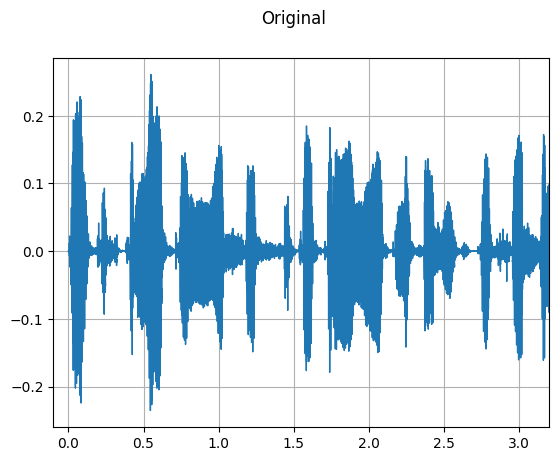

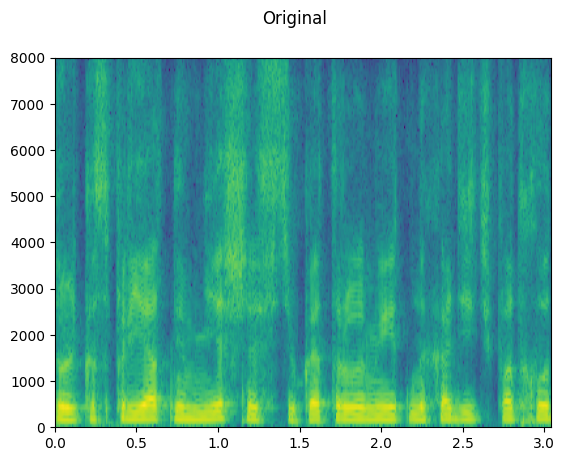

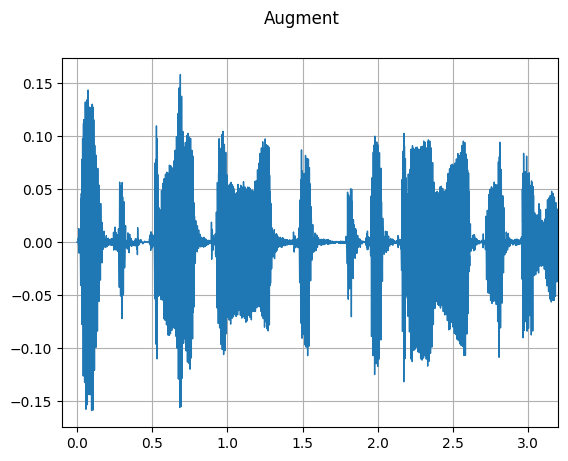

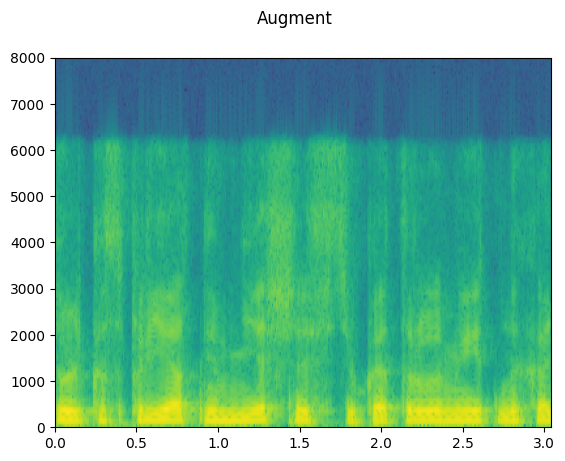

In [16]:
rand_int = random.randint(0, len(ds_train)-1)
print(ds_train[rand_int]["transcription"])
augment_example = aug_example(ds_train[rand_int]["audio"])
ipd.Audio(data=ds_train[rand_int]["audio"]['array'],rate=ds_train[rand_int]["audio"]['sampling_rate']) #original audio

In [17]:
ipd.Audio(data=augment_example['array'],rate=augment_example['sampling_rate']) #augment audio

# Функция для аугментирования данных в ходе обучения модели

In [18]:
import numpy as np
import random
from random import choices
from datasets import Dataset


def aug_sample(sample):
    probability = 0.5
    sampling_rate = 16000
    if random.randint(0,100)/100 > probability:
        sample = torch.Tensor([sample])
        random_effects=0
        effects = [
            ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
            ["speed", "0.8"],  # reduce the speed
            #["reverb", "-w"],  # Reverbration gives some dramatic feeling
        ]

        if random_effects:
            effects = choices(effects, k=random_effects)
        effects.append(["rate", f"{16000}"])
        wav, _ = torchaudio.sox_effects.apply_effects_tensor(sample, sampling_rate, effects)
        wav = wav[0].tolist()
    else:
        wav = sample
    return wav

In [19]:
rand_int = random.randint(0, len(ds_train)-1)

print("Target text:", ds_train[rand_int]["transcription"])
print("Input array shape:", ds_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", ds_train[rand_int]["audio"]["sampling_rate"])


Target text: коммунизм это нихуя ни будущее
Input array shape: (53281,)
Sampling rate: 16000


# Подготовка данных для обучения

In [20]:
def prepare_dataset(batch):
    #print(batch)
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["transcription"]).input_ids
    return batch

ds_train = ds_train.map(prepare_dataset, remove_columns=ds_train.column_names)
print('train')
ds_test = ds_test.map(prepare_dataset, remove_columns=ds_test.column_names)
print('test')

  0%|          | 0/20000 [00:00<?, ?ex/s]/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
100%|██████████| 20000/20000 [00:31<00:00, 634.57ex/s]


train


100%|██████████| 4985/4985 [00:07<00:00, 674.52ex/s]


test


In [21]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods

        input_features = [{"input_values": aug_sample(feature["input_values"])} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [22]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

# Обучение

In [23]:
import datasets
wer_metric = datasets.load_metric("wer")

/tmp/ipykernel_3136/2798393314.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = datasets.load_metric("wer")


In [24]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


In [25]:
model.freeze_feature_encoder()

In [26]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
  output_dir='pisets/results',
  group_by_length=True,
  per_device_train_batch_size= 16,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=10,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=400,
  eval_steps=400,
  logging_steps=400,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  push_to_hub=True,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=processor.feature_extractor,
)

trainer.train()

/usr/src/app/pisets/pisets/results is already a clone of https://huggingface.co/doooori/results. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 6250


Step,Training Loss,Validation Loss,Wer
400,0.589900,0.335262,0.285076
800,0.563300,0.331432,0.319543
1200,0.563700,0.323541,0.304311
1600,0.496800,0.351787,0.319195
2000,0.451600,0.313543,0.295230
2400,0.429900,0.307981,0.295375
2800,0.383500,0.311726,0.292880
3200,0.357600,0.291510,0.278258
3600,0.327900,0.290285,0.272311
4000,0.306600,0.284503,0.267843


The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4985
  Batch size = 8
Saving model checkpoint to pisets/results/checkpoint-400
Configuration saved in pisets/results/checkpoint-400/config.json
Model weights saved in pisets/results/checkpoint-400/pytorch_model.bin
Feature extractor saved in pisets/results/checkpoint-400/preprocessor_config.json
Feature extractor saved in pisets/results/preprocessor_config.json
Several commits (2) will be pushed upstream.
Deleting older checkpoint [pisets/results/checkpoint-3200] due to args.save_total_limit
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your la

TrainOutput(global_step=6250, training_loss=0.3703145202636719, metrics={'train_runtime': 14628.834, 'train_samples_per_second': 13.672, 'train_steps_per_second': 0.427, 'total_flos': 2.7703582963724632e+19, 'train_loss': 0.3703145202636719, 'epoch': 10.0})